In [1]:
import pandas as pd
import re

# Cargar los archivos principales
job_postings = pd.read_csv("dataset2/job_postings.csv")
companies = pd.read_csv("dataset2/companies.csv")
company_industries = pd.read_csv("dataset2/company_industries.csv")
company_specialities = pd.read_csv("dataset2/company_specialities.csv")
employee_counts = pd.read_csv("dataset2/employee_counts.csv")
benefits = pd.read_csv("dataset2/benefits.csv")
job_industries = pd.read_csv("dataset2/job_industries.csv")
job_skills = pd.read_csv("dataset2/job_skills.csv")

In [2]:
# Unir habilidades y beneficios a las ofertas
job_data = job_postings.merge(job_skills, on="job_id", how="left") \
                       .merge(job_industries, on="job_id", how="left") \
                       .merge(benefits, on="job_id", how="left")


In [3]:
job_data.columns

Index(['job_id', 'company_id', 'title', 'description', 'max_salary',
       'med_salary', 'min_salary', 'pay_period', 'formatted_work_type',
       'location', 'applies', 'original_listed_time', 'remote_allowed',
       'views', 'job_posting_url', 'application_url', 'application_type',
       'expiry', 'closed_time', 'formatted_experience_level', 'skills_desc',
       'listed_time', 'posting_domain', 'sponsored', 'work_type', 'currency',
       'compensation_type', 'skill_abr', 'industry_id', 'inferred', 'type'],
      dtype='object')

In [4]:
job_data.shape

(60627, 31)

In [5]:
# 🔎 Seleccionar solo las columnas útiles
columnas_nlp = [
    "job_id", "title", "description",
    "skill_abr", "min_salary", "max_salary",
    "formatted_experience_level"
]

In [6]:
columnas_nlp = [col for col in columnas_nlp if col in job_data.columns]  # por si alguna falta
columnas_nlp


['job_id',
 'title',
 'description',
 'skill_abr',
 'min_salary',
 'max_salary',
 'formatted_experience_level']

In [7]:
print(job_data.columns.tolist())

['job_id', 'company_id', 'title', 'description', 'max_salary', 'med_salary', 'min_salary', 'pay_period', 'formatted_work_type', 'location', 'applies', 'original_listed_time', 'remote_allowed', 'views', 'job_posting_url', 'application_url', 'application_type', 'expiry', 'closed_time', 'formatted_experience_level', 'skills_desc', 'listed_time', 'posting_domain', 'sponsored', 'work_type', 'currency', 'compensation_type', 'skill_abr', 'industry_id', 'inferred', 'type']


In [8]:
job_nlp_data = job_data[columnas_nlp].copy()

In [9]:
# Limpieza de texto
def clean_text(text):
    if pd.isnull(text):
        return ""
    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

In [10]:
columnas_a_ver = ["title", "description", "skill_abr", "min_salary", "max_salary", "formatted_experience_level"]
print(job_nlp_data[columnas_a_ver].isna().sum())

title                             0
description                       2
skill_abr                      1004
min_salary                    33998
max_salary                    33998
formatted_experience_level    17549
dtype: int64


In [11]:
for col in ["title", "description",  "skill_abr", "formatted_experience_level"]:
    if col in job_nlp_data.columns:
        job_nlp_data[col] = job_nlp_data[col].apply(clean_text)

In [12]:
# Campo combinado para NLP
campos_texto = [col for col in ["title", "description",  "skill_abr", "formatted_experience_level"] if col in job_nlp_data.columns]
campos_texto

['title', 'description', 'skill_abr', 'formatted_experience_level']

In [13]:
job_nlp_data["full_text"] = job_nlp_data[campos_texto].agg(" ".join, axis=1)
job_nlp_data

,job_id,title,description,skill_abr,min_salary,max_salary,formatted_experience_level,full_text
0,85008768,licensed insurance agent,while many industries were hurt by the last fe...,sale,45760.0,52000.0,,licensed insurance agent while many industries...
1,85008768,licensed insurance agent,while many industries were hurt by the last fe...,sale,45760.0,52000.0,,licensed insurance agent while many industries...
2,85008768,licensed insurance agent,while many industries were hurt by the last fe...,sale,45760.0,52000.0,,licensed insurance agent while many industries...
3,85008768,licensed insurance agent,while many industries were hurt by the last fe...,sale,45760.0,52000.0,,licensed insurance agent while many industries...
4,85008768,licensed insurance agent,while many industries were hurt by the last fe...,sale,45760.0,52000.0,,licensed insurance agent while many industries...
...,...,...,...,...,...,...,...,...
60622,3701373527,area director of business development,nexion health management affiliates operate 56...,sale,NaN,NaN,,area director of business development nexion h...
60623,3701373527,area director of business development,nexion health management affiliates operate 56...,sale,NaN,NaN,,area director of business development nexion h...
60624,3701373527,area director of business development,nexion health management affiliates operate 56...,sale,NaN,NaN,,area director of business development nexion h...
60625,3701373527,area director of business development,nexion health management affiliates operate 56...,sale,NaN,NaN,,area director of business development nexion h...


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

In [15]:
# 🔠 Vectorización TF-IDF
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(job_nlp_data["full_text"])

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=1500,
    stop_words='english',
    max_df=0.85,
    min_df=5,
    ngram_range=(1, 2)
)

# Aplica TF-IDF sobre full_text
text_features = tfidf.fit_transform(job_nlp_data["full_text"])
print("TF-IDF shape:", text_features.shape)

TF-IDF shape: (60627, 1500)


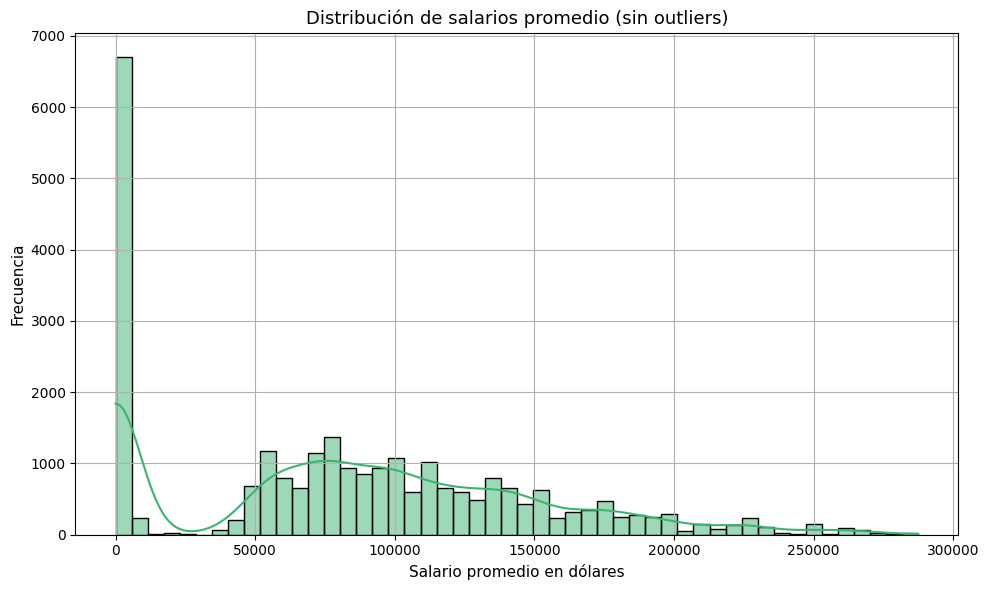

In [20]:
limite = job_data['avg_salary'].quantile(0.99)
filtered_job_data = job_data[job_data['avg_salary'] < limite]

plt.figure(figsize=(10, 6))
sns.histplot(filtered_job_data['avg_salary'], bins=50, kde=True, color='mediumseagreen')
plt.title('Distribución de salarios promedio (sin outliers)', fontsize=13)
plt.xlabel('Salario promedio en dólares', fontsize=11)
plt.ylabel('Frecuencia', fontsize=11)
plt.grid(True)
plt.tight_layout()
plt.show()

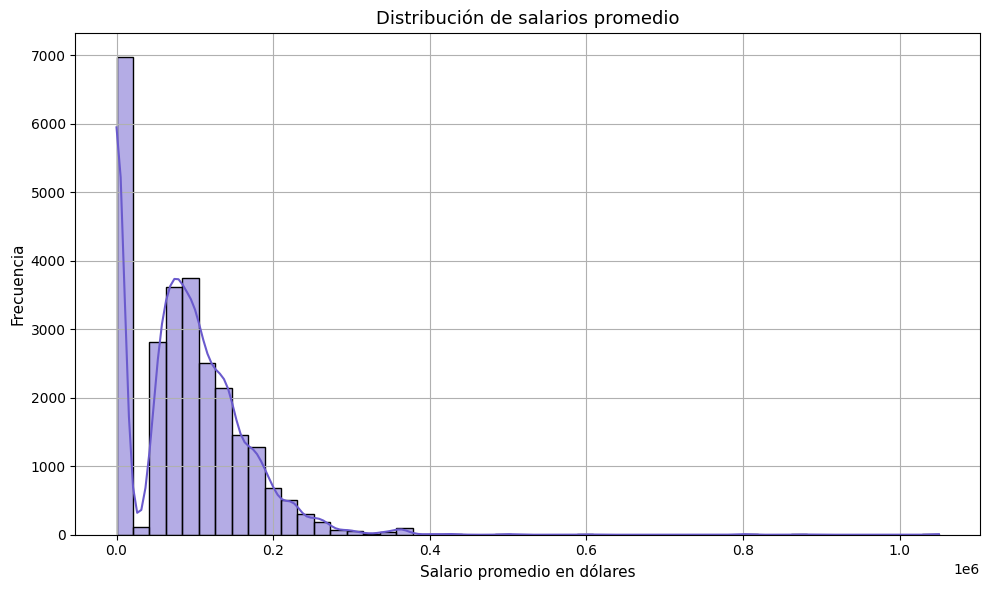

In [21]:
plt.figure(figsize=(10, 6))
sns.histplot(job_data['avg_salary'], bins=50, kde=True, color='slateblue')
plt.title('Distribución de salarios promedio', fontsize=13)
plt.xlabel('Salario promedio en dólares', fontsize=11)
plt.ylabel('Frecuencia', fontsize=11)
plt.grid(True)
plt.tight_layout()
plt.show()

In [22]:
job_data[job_data['min_salary'] < 10000][['min_salary', 'max_salary']].describe()

,min_salary,max_salary
count,6943.000000,6943.000000
mean,247.991077,430.932559
std,1081.385603,4055.762927
min,10.000000,10.000000
25%,19.000000,24.000000
50%,25.000000,30.570000
75%,40.000000,50.000000
max,9431.000000,180000.000000


In [23]:
import numpy as np

# Calcular salario promedio si aún no lo has hecho
job_data['avg_salary'] = (job_data['min_salary'] + job_data['max_salary']) / 2

# Función para escalar
def escalar_salario(row):
    if row['pay_period'] == 'HOURLY':
        return row['avg_salary'] * 40 * 52  # 40 horas/semana * 52 semanas
    elif row['pay_period'] == 'MONTHLY':
        return row['avg_salary'] * 12
    elif row['pay_period'] == 'YEARLY':
        return row['avg_salary']
    else:
        return np.nan  # Por si hay algún valor inesperado

# Aplicar al DataFrame
job_data['avg_salary_annual'] = job_data.apply(escalar_salario, axis=1)



In [25]:
job_data['pay_period'].value_counts(dropna=False)


pay_period
NaN        30943
YEARLY     20972
HOURLY      8344
MONTHLY      368
Name: count, dtype: int64

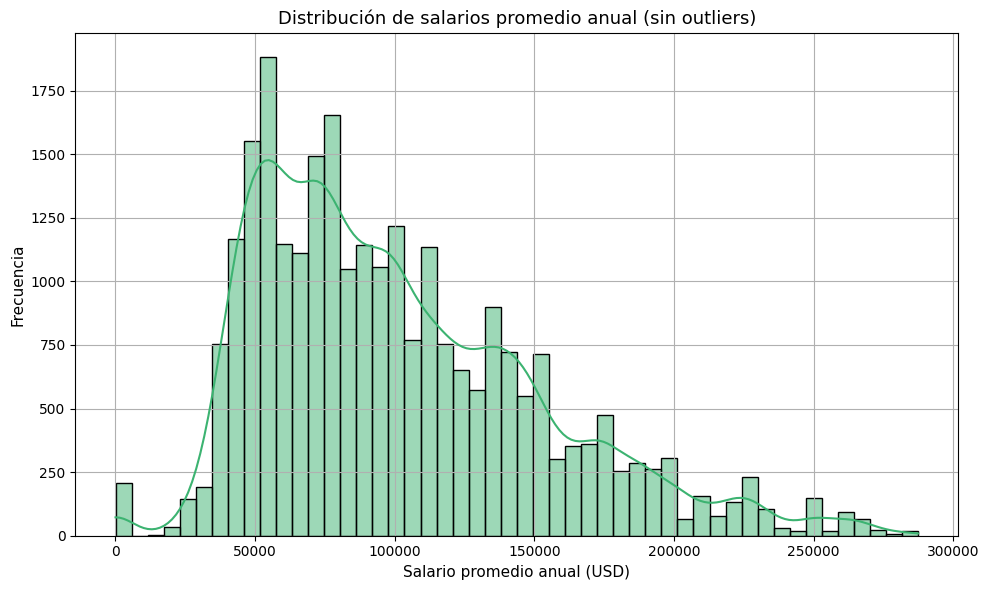

In [28]:
# Calcular el límite del percentil 99
limite = job_data['avg_salary_annual'].quantile(0.99)

# Filtrar los salarios por debajo de ese límite
filtered_job_data = job_data[job_data['avg_salary_annual'] < limite]

# Graficar la distribución sin los outliers más altos
plt.figure(figsize=(10, 6))
sns.histplot(filtered_job_data['avg_salary_annual'], bins=50, kde=True, color='mediumseagreen')
plt.title('Distribución de salarios promedio anual (sin outliers)', fontsize=13)
plt.xlabel('Salario promedio anual (USD)', fontsize=11)
plt.ylabel('Frecuencia', fontsize=11)
plt.grid(True)
plt.tight_layout()
plt.show()


In [31]:
job_nlp_data["avg_annual"] = job_data['avg_salary_annual']

job_nlp_data["max_salary"] = job_nlp_data["avg_annual"]
job_nlp_data["min_salary"] = job_nlp_data["avg_annual"]
job_nlp_data["avg_salary"] = job_nlp_data["avg_annual"]

In [32]:
import zipfile
import joblib

# ✅ Paso 1: Guardar el DataFrame procesado como CSV
job_nlp_data.to_csv('dataset2_procesado.csv', index=False)

# ✅ Paso 2: Comprimirlo en un archivo ZIP
with zipfile.ZipFile('dataset2_procesado.zip', 'w', zipfile.ZIP_DEFLATED) as zipf:
    zipf.write('dataset2_procesado.csv', arcname='dataset2_procesado.csv')

print("✅ Datos procesados guardados como ZIP correctamente.")

# ✅ Paso 3: Guardar el vectorizador TF-IDF
joblib.dump(tfidf, 'dataset2_tfidf_vectorizer.pkl')

print("✅ Vectorizador TF-IDF guardado correctamente.")

✅ Datos procesados guardados como ZIP correctamente.
✅ Vectorizador TF-IDF guardado correctamente.
